<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband/WidebandAna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%pip -q install uproot
import uproot
pd.options.display.max_columns = None


In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

In [3]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if False:
  !apt-get -qq install krb5-user
  !wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
  import os
  os.environ['KRB5_CONFIG'] = 'krb5.conf'

  !kinit oksuzian@FNAL.GOV
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/pnfs/mu2e/scratch/users/macndev/wideband/newreco/rec.mu2e.CRV_wideband_cosmics.crvaging-005-junk.001137.root drive/MyDrive/Wideband/

In [5]:
root_file = 'drive/MyDrive/Wideband/rec.mu2e.CRV_wideband_cosmics.crvaging-005-junk.001137.root'
tree = uproot.open(root_file+":run")
df = tree.arrays(filter_name=['PEs', 'timeSinceSpill', 'spillNumber', 'eventNumber'],library="pd")
df[df < 0] = 0

/usr/local/lib/python3.7/dist-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


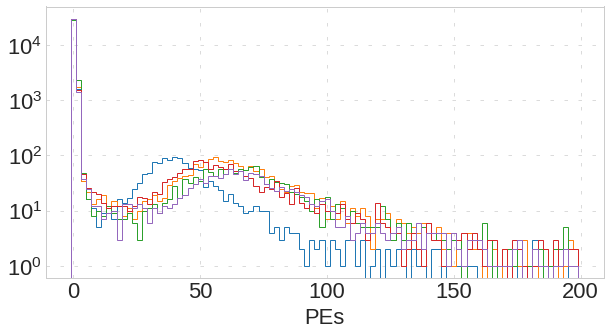

In [6]:
plt.hist(df['PEs[0][63]'], histtype='step', bins=100, range=(-1, 199));
plt.hist(df['PEs[1][63]'], histtype='step', bins=100, range=(-1, 199));
plt.hist(df['PEs[2][63]'], histtype='step', bins=100, range=(-1, 199));
plt.hist(df['PEs[3][63]'], histtype='step', bins=100, range=(-1, 199));
plt.hist(df['PEs[4][63]'], histtype='step', bins=100, range=(-1, 199));

plt.xlabel('PEs')
plt.yscale('log')

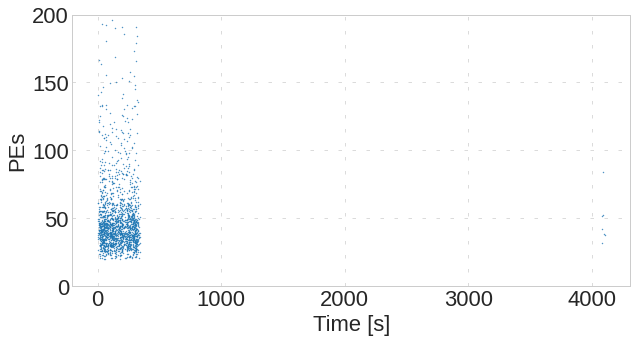

In [7]:
df_cut = df.loc[df['PEs[0][0]']>20]
plt.plot(df_cut['spillNumber'] + df_cut['timeSinceSpill[0][0]']/1e9, df_cut['PEs[0][0]'], '.', markersize=0.8)
plt.ylim(0,200)
plt.ylabel('PEs')
plt.xlabel('Time [s]');

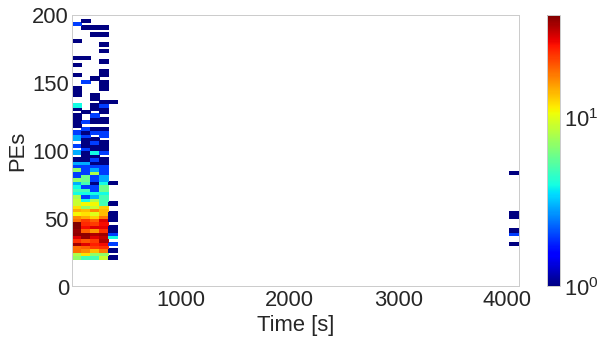

In [8]:
plt.hist2d(df_cut['spillNumber'] + df_cut['timeSinceSpill[0][0]']/1e9, df_cut['PEs[0][0]'], bins=(50,300), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.ylim(0,200)
plt.colorbar()
plt.ylabel('PEs')
plt.xlabel('Time [s]');

In [11]:
feb_map = []
feb_map.append((0, 2, 3)) # feb_map[0] is connected to (module_number=0, layer1=2, layer2=3)
feb_map.append((1, 0, 1)) # feb_map[1] is connected to (module_number=1, layer1=0, layer2=1)
feb_map.append((1, 2, 3))
feb_map.append((2, 0, 1))
feb_map.append((3, 2, 3))
MAX_FEB = len(feb_map) # Max number of FEB in the configuration

In [12]:
for feb in range(MAX_FEB):
  list_1 = list()
  for x in range(0, 32):
    if (feb==0 or feb==3 or feb==4) and (x<2  or x==14 or x==15 or x==16 or x==17 or x==30 or x==31):
      continue
    list_1.append('PEs[%d][%d]'%(feb,x))
  df['FEB%d_%d'%(feb,x//32)] = df[list_1].sum(axis=1)

  list_1 = list()
  for x in range(32, 64):
    if (feb==0 or feb==3 or feb==4) and (x<34 or x==46 or x==47 or x==48 or x==49 or x==62 or x==63):
      continue

    list_1.append('PEs[%d][%d]'%(feb,x))
  df['FEB%d_%d'%(feb,x//32)] = df[list_1].sum(axis=1)

In [13]:
df_filt = df.query('FEB0_0>10 & FEB0_1>10 & FEB3_0>10 & FEB3_1>10 & FEB4_0>10 & FEB4_1>10')
df_failed = df_filt.query('FEB1_0<10 | FEB1_1<10 | FEB2_0<10 | FEB2_1<10')

In [14]:
PADS_BETWEEN_MODULES = 10.16 # insulation pads between modules in cm
MAX_PE = 75 # Max PE value to display
LAYER_OFFSET = 4.2 # cm
COUNTER_WIDTH = 5.0 # cm
COUNTER_HEIGHT = 2.0 # cm

gapBetweenLayers =  0.9525  # cm - taken from Offline/Mu2eG4/geom/crv_counters_v08.txt
aluminumSheetThickness = 0.3175 # cm
strongBackThickness = 1.27    # cm

MODULE_HEIGHT = 4*COUNTER_HEIGHT+3*gapBetweenLayers+aluminumSheetThickness+strongBackThickness


def plot_event(spillNumber, eventNumber):
  norm = matplotlib.colors.LogNorm(vmin=2, vmax=MAX_PE)
  m = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)

  df_ = df_failed.query('spillNumber==%d and eventNumber==%d'%(spillNumber, eventNumber))

  num_modules=4
  xy=[]
  for x in range(0,15):
    for y in range(0,4):
      for n in range(0,num_modules):
        xy.append([COUNTER_WIDTH*x+LAYER_OFFSET*y,
                  -y*(gapBetweenLayers+COUNTER_HEIGHT)-n*(MODULE_HEIGHT+PADS_BETWEEN_MODULES)])

  fig, axs = plt.subplots(1,1, figsize=(14,14))
  axs.set_aspect(aspect='equal')
  axs.set_xlim(-10, 105)
  axs.set_ylim(-80, 10)
  axs.set_ylabel("y [cm]")
  axs.set_xlabel("x [cm]")
  for x, y in xy:
      rect1 = plt.Rectangle((x, y-1), 10, 2, fill=None)
      axs.add_patch(rect1)

  for feb in range(0,MAX_FEB):
    layer_list = (feb_map[feb][1], feb_map[feb][2]) # Local layers that FEB is connected with a module 
    module_num = feb_map[feb][0] # Module number FEB is connected to
    for chan in range(0,64):

      local_layer = layer_list[chan//32] # Layer within a module (0,1,2,3)
      global_layer = local_layer + module_num*4 # Layer within a stack of module (0,1,2,3,4,5...)

      y = -global_layer*(COUNTER_HEIGHT+gapBetweenLayers) \
          -module_num*(PADS_BETWEEN_MODULES+strongBackThickness-gapBetweenLayers+aluminumSheetThickness) \

      x = COUNTER_WIDTH/2*(chan%32)+LAYER_OFFSET*local_layer+COUNTER_WIDTH/4

      z = df_['PEs[%d][%d]'%(feb,chan)].iloc[0]
      z = np.clip(z, 0.1, MAX_PE) # Constrain PE to a range from 0.1 to  
      rect = plt.Circle((x, y), 0.8*z/MAX_PE, fc=m.to_rgba(z)) 
      axs.add_patch(rect)
    
    plt.title('Spill: %d, Event: %d'%(spillNumber, eventNumber))

8 131
11 79
26 24
28 39
35 147
39 3
39 7
39 8
39 20
39 35
39 38
39 59
39 62
39 75
39 83
39 88
39 97
39 100
39 107
39 109
39 111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


39 129
39 148
39 182
39 195


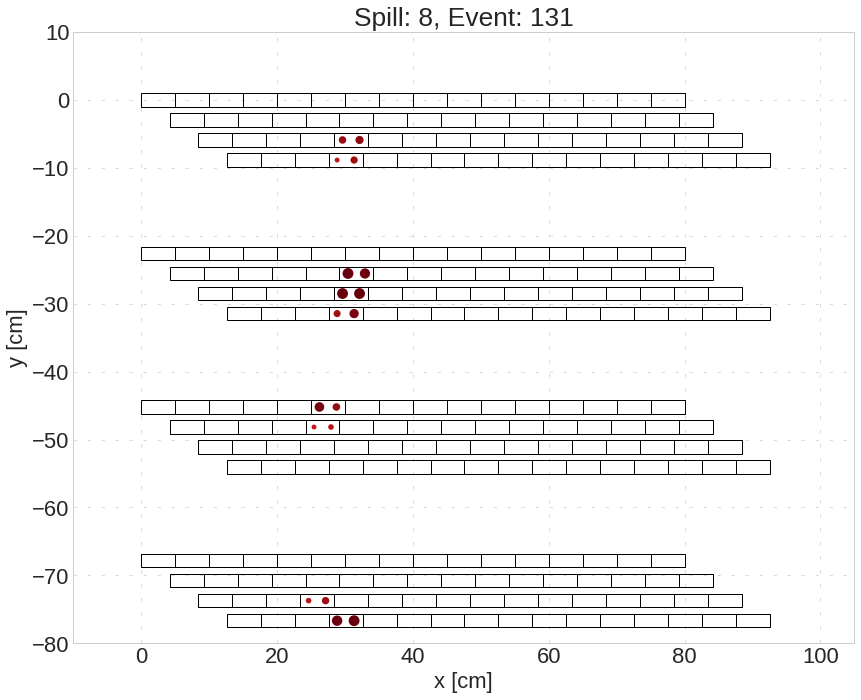

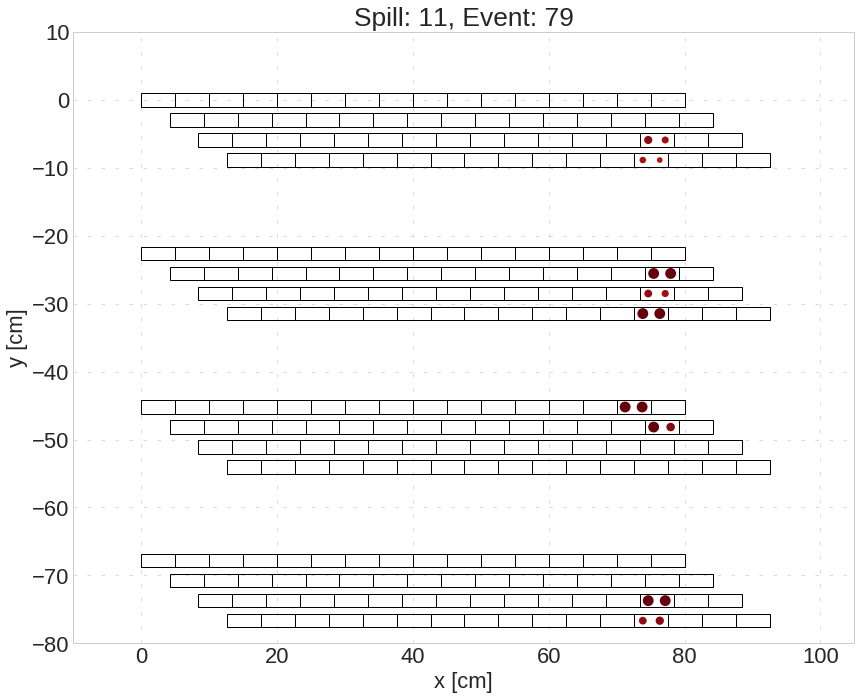

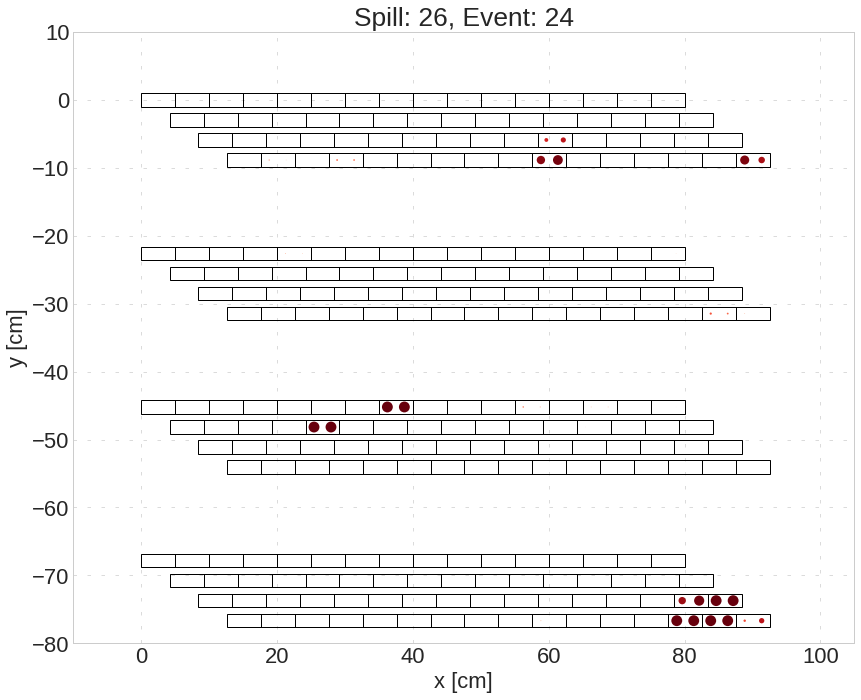

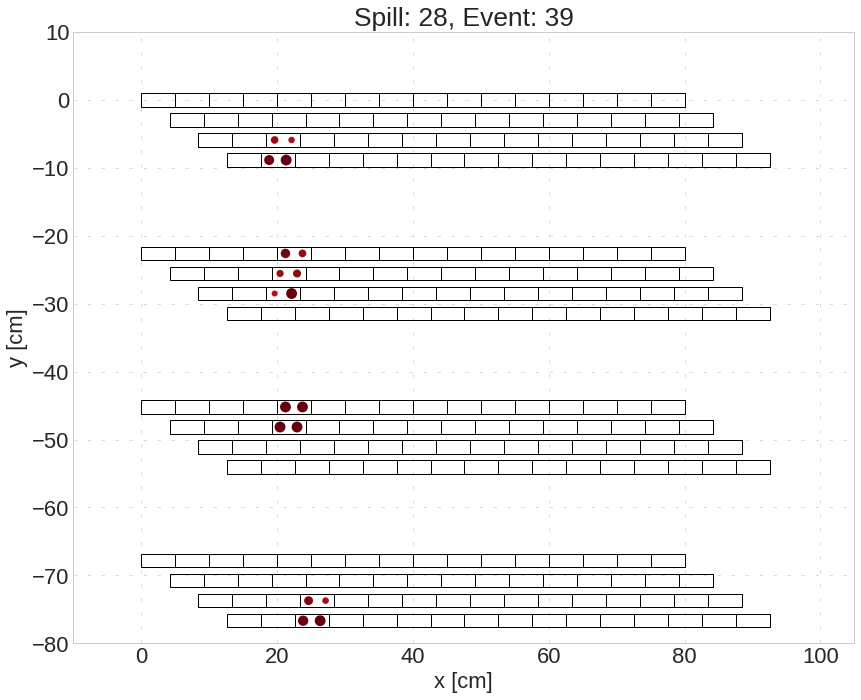

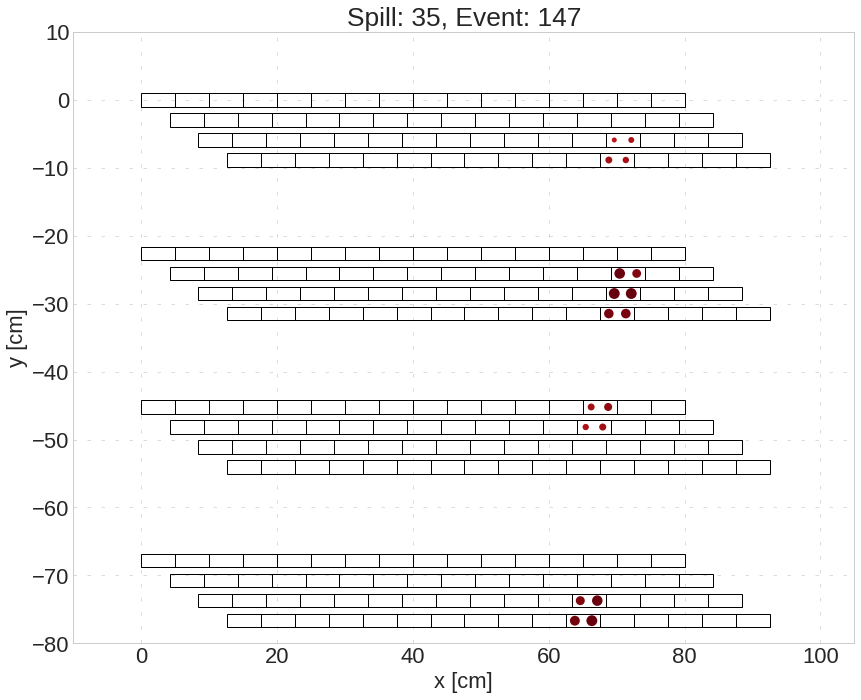

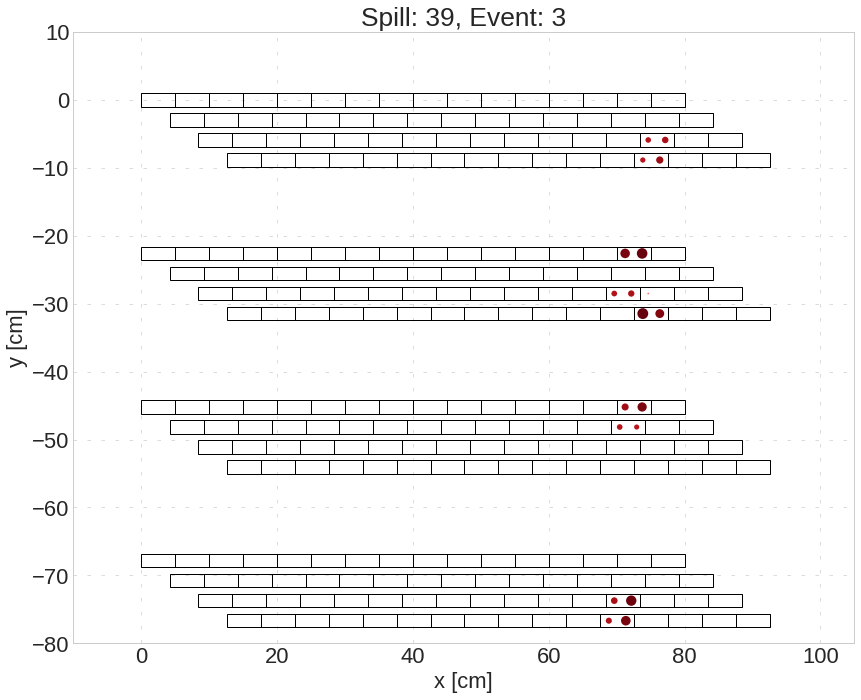

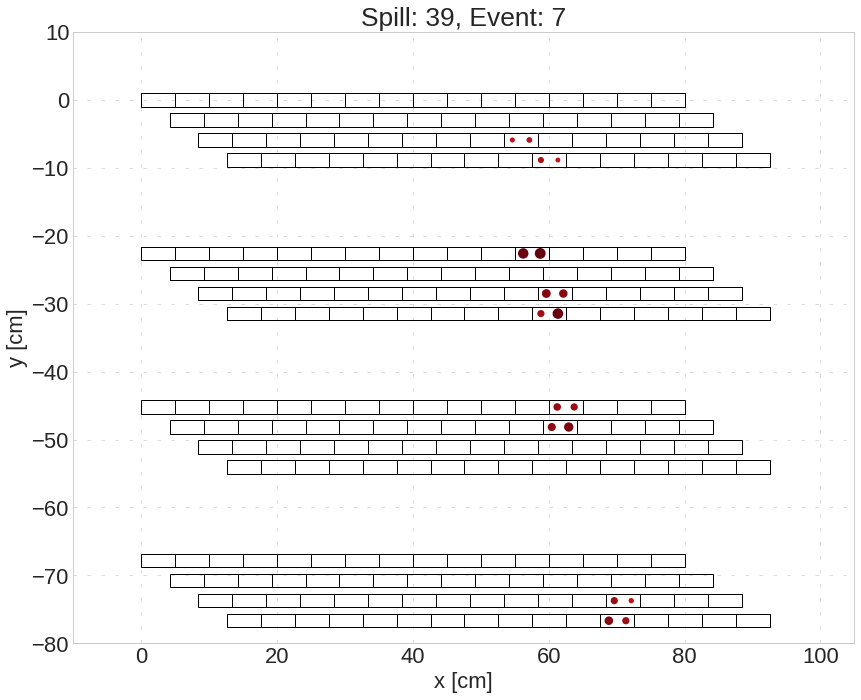

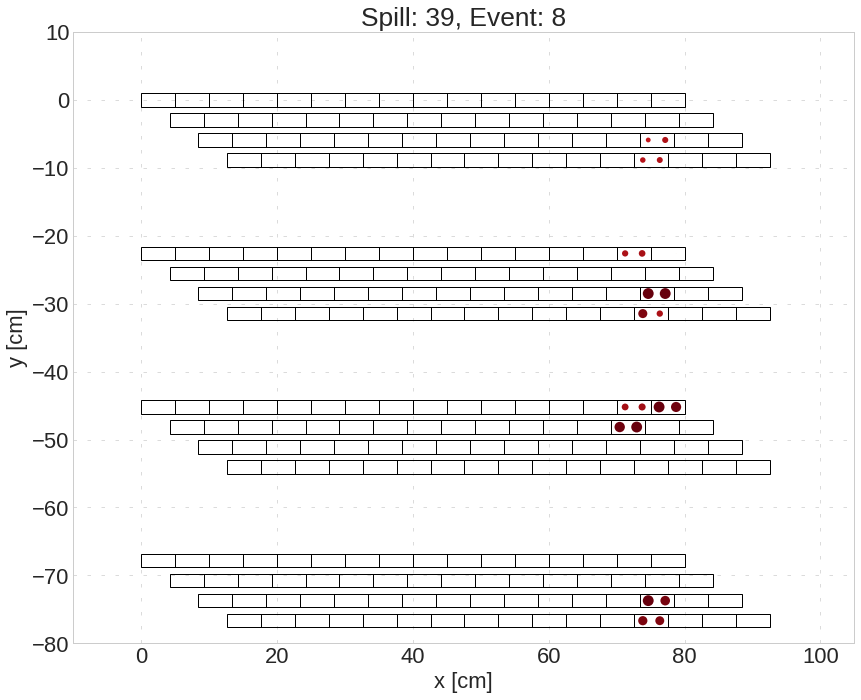

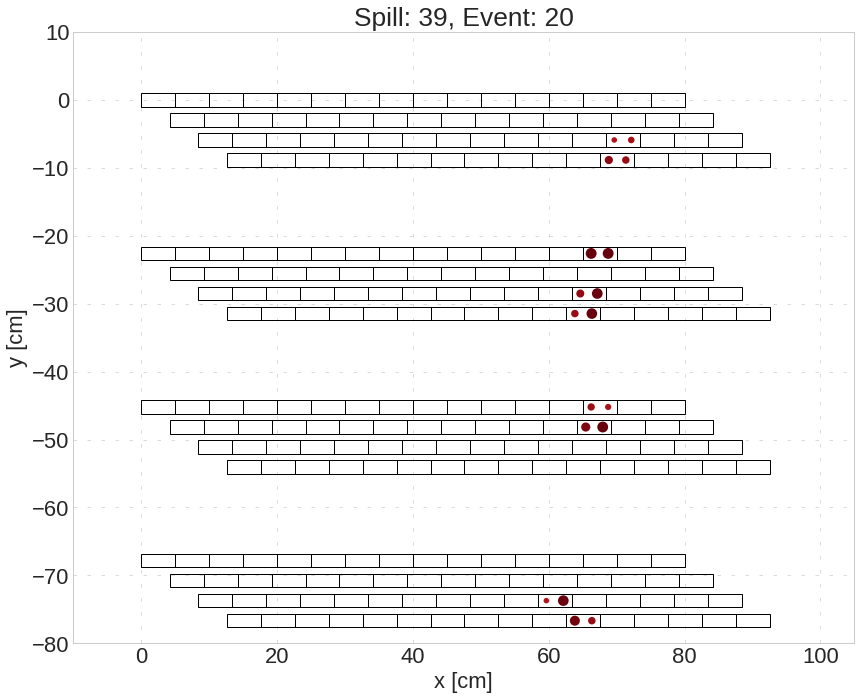

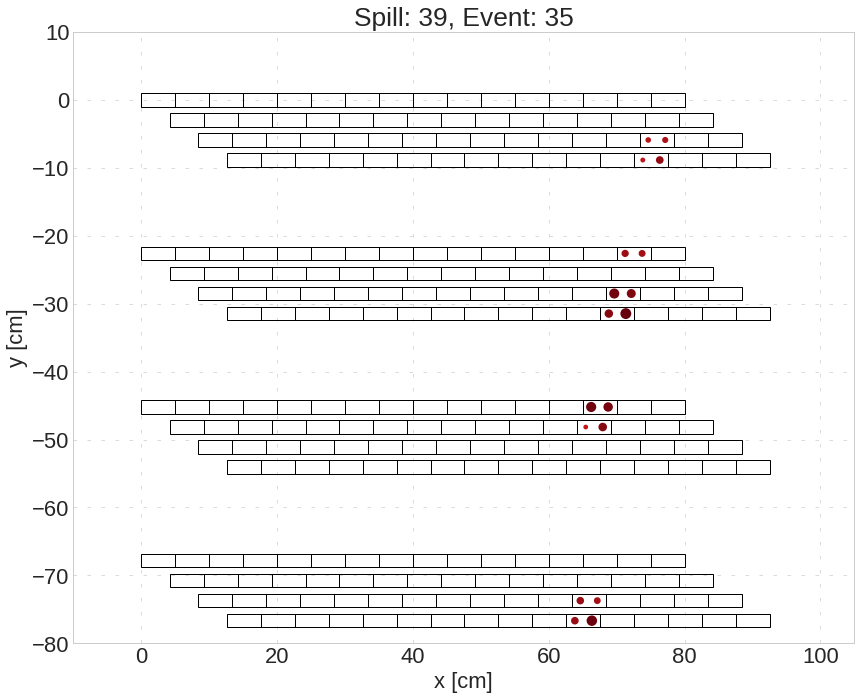

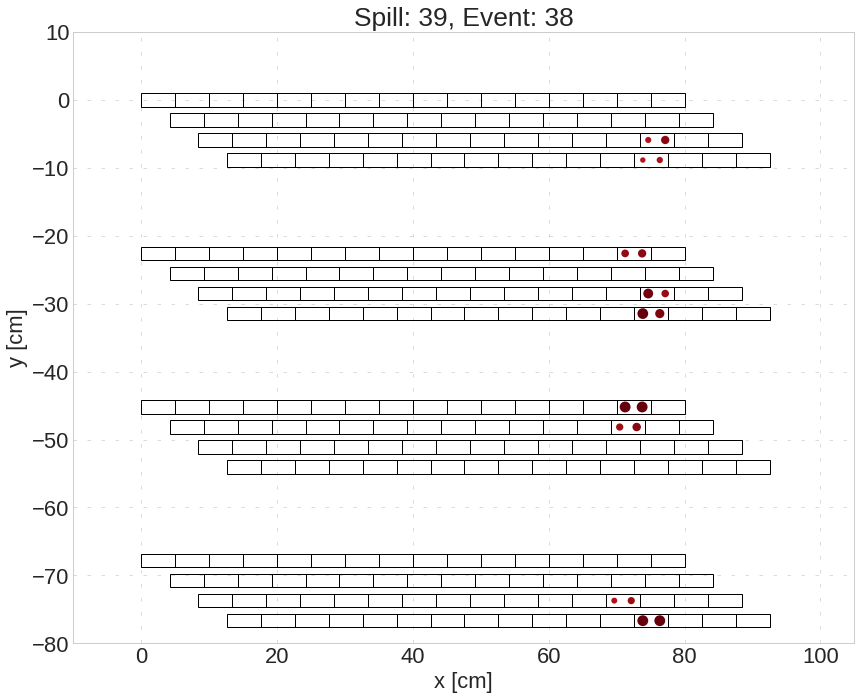

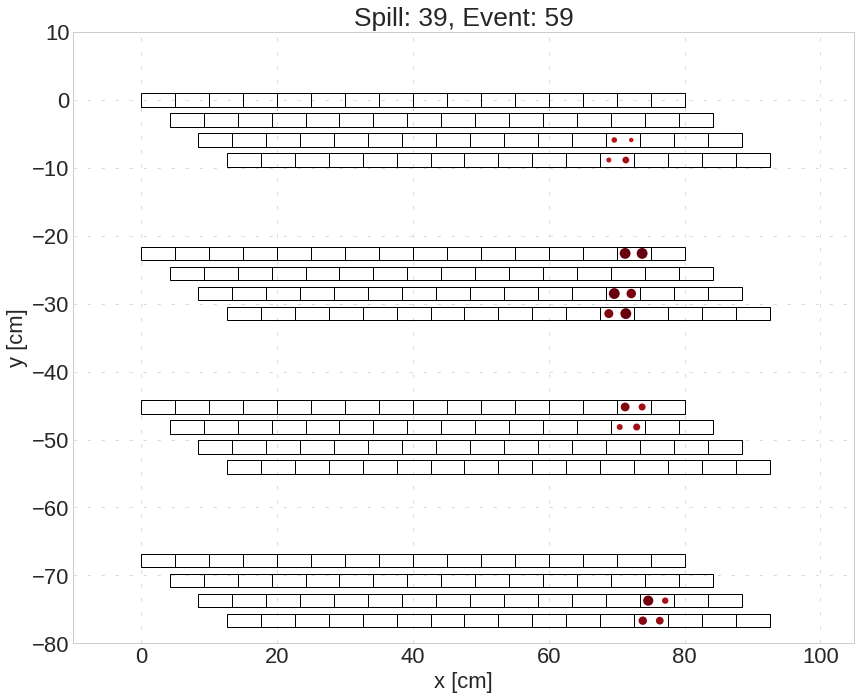

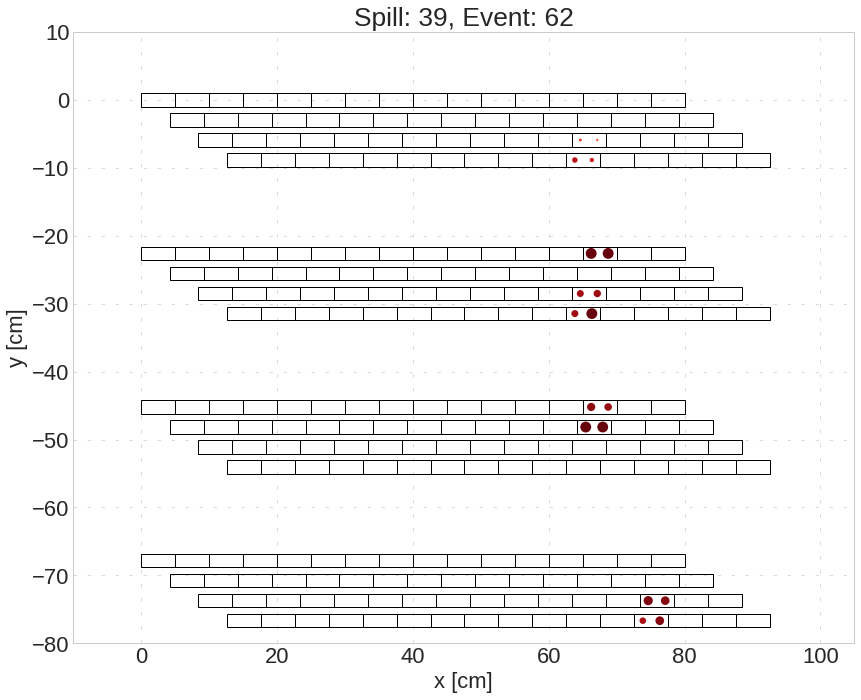

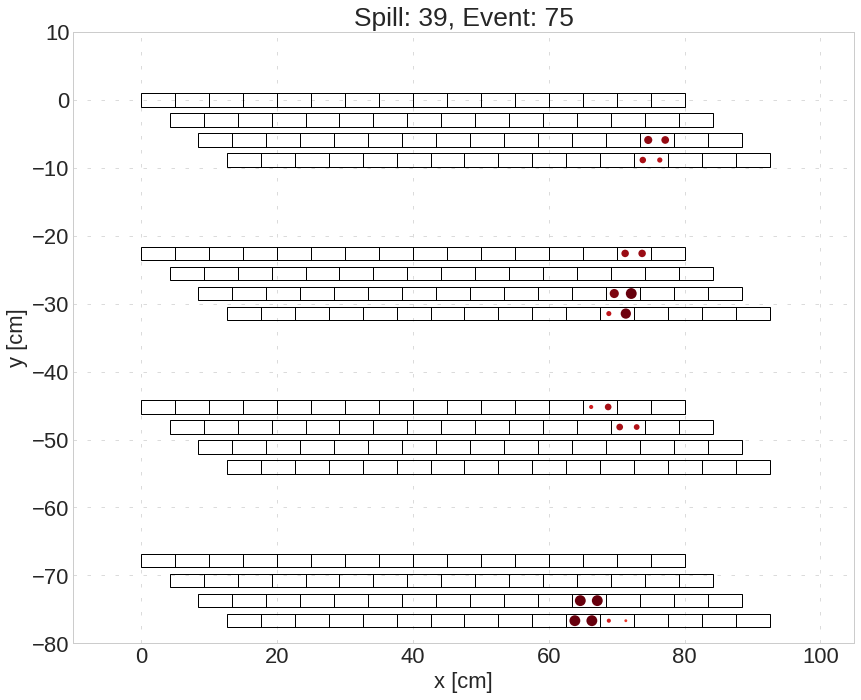

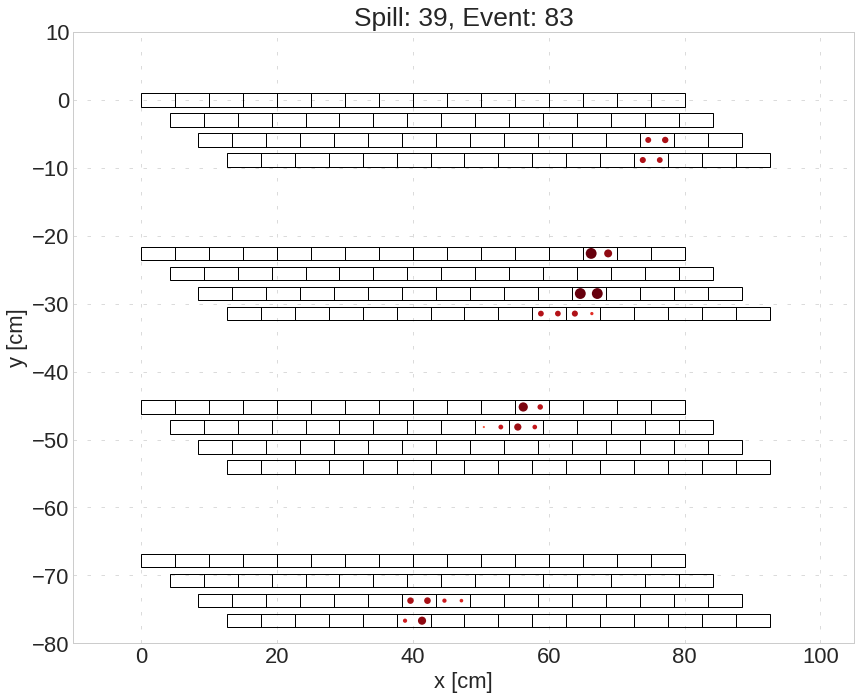

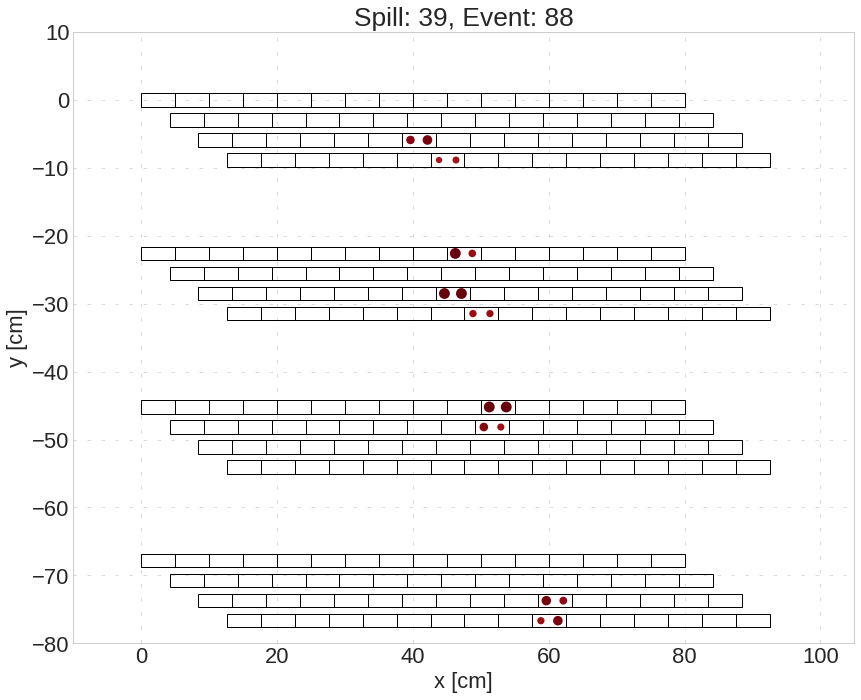

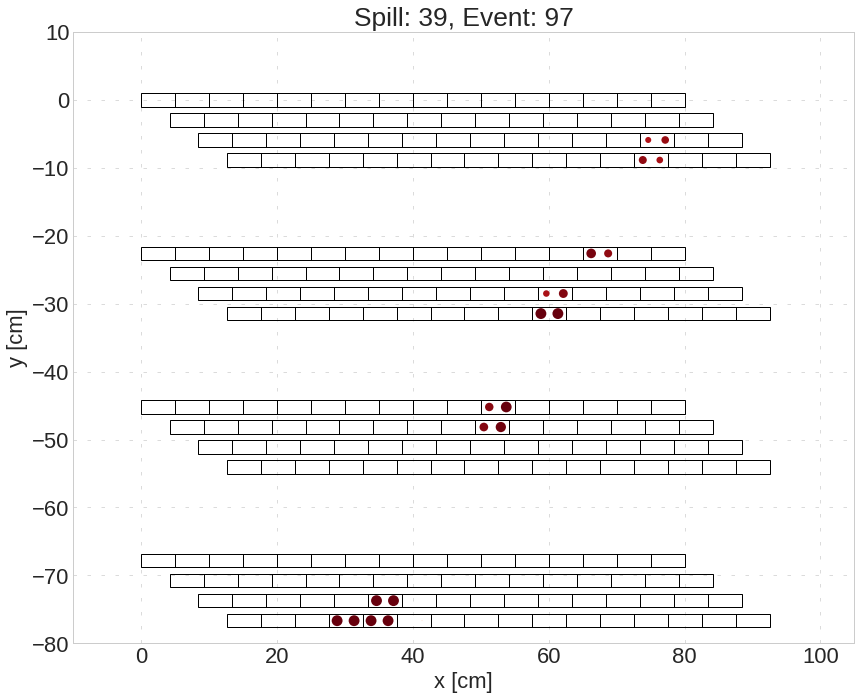

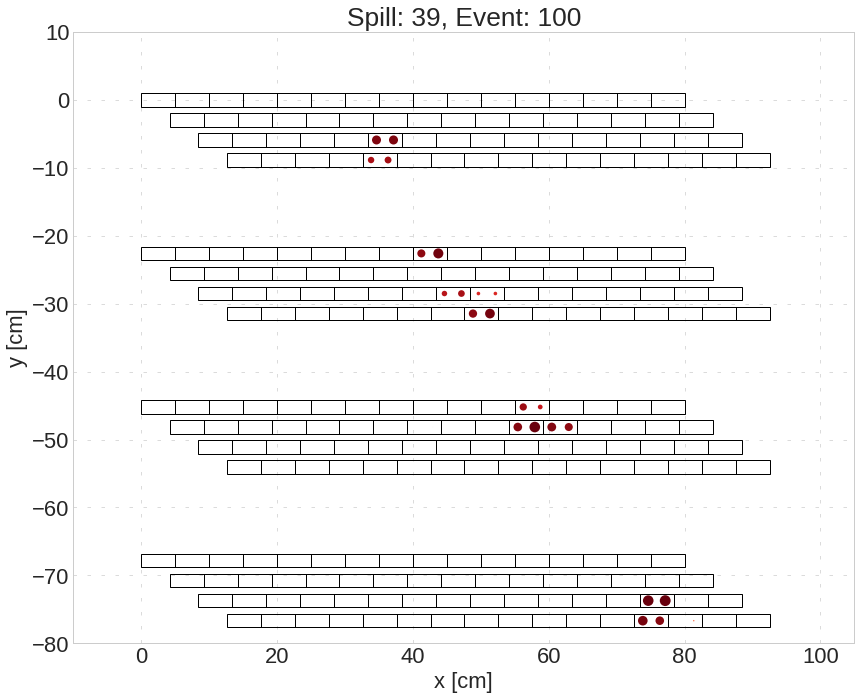

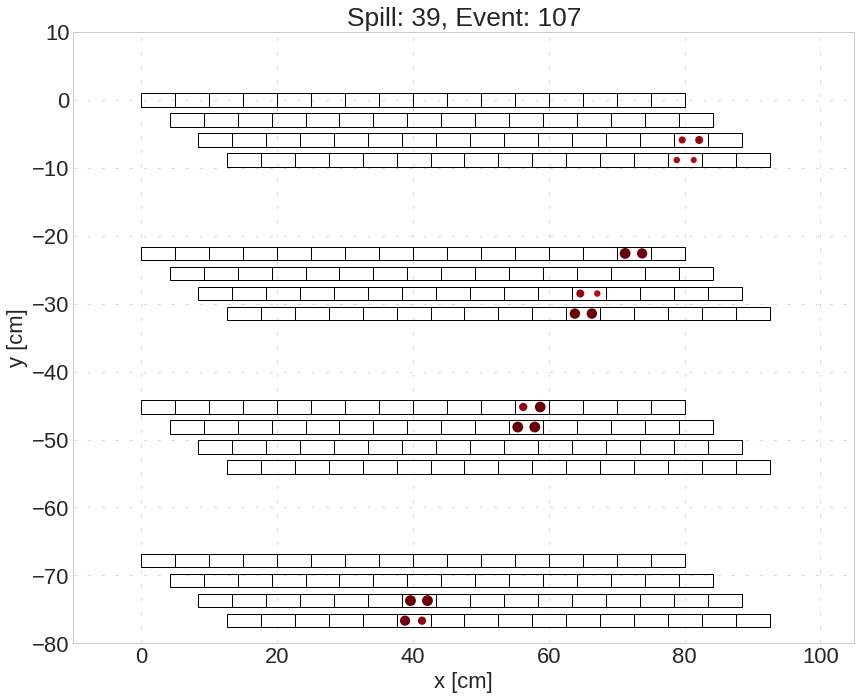

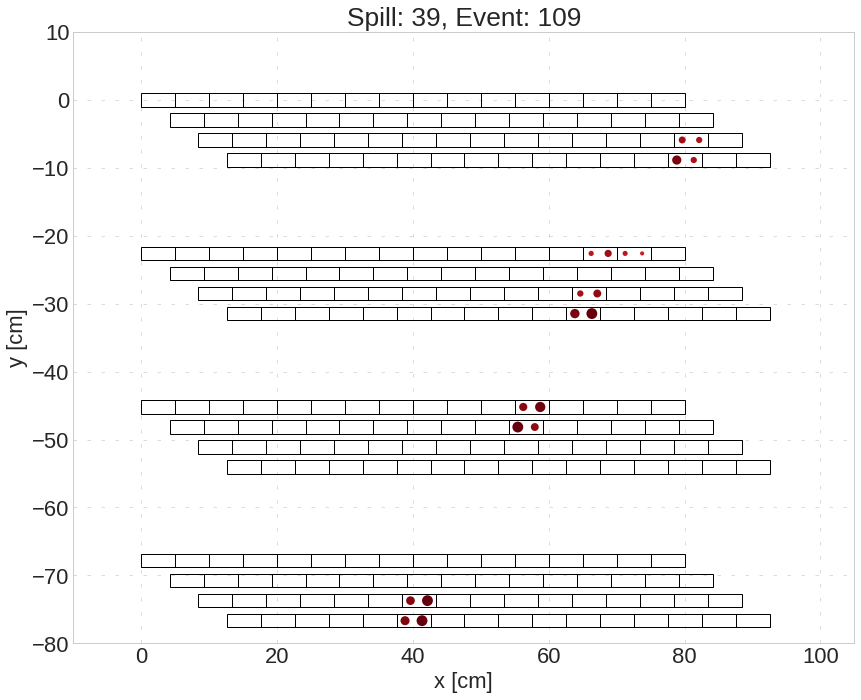

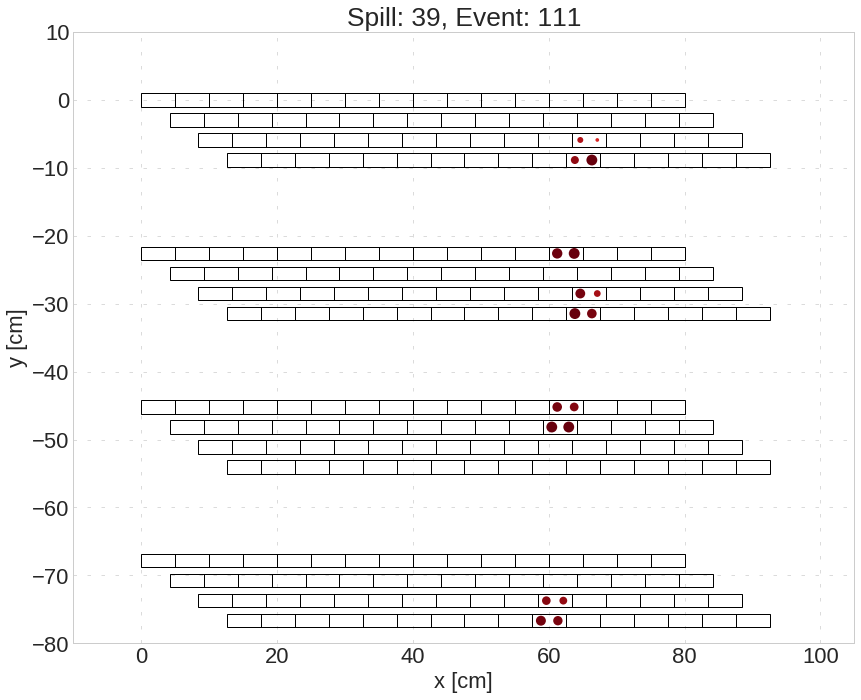

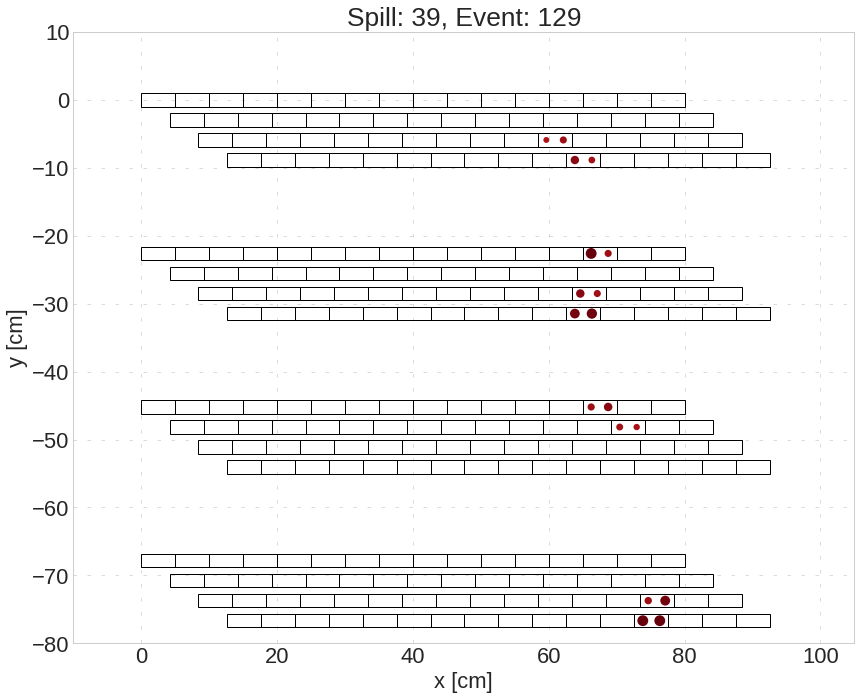

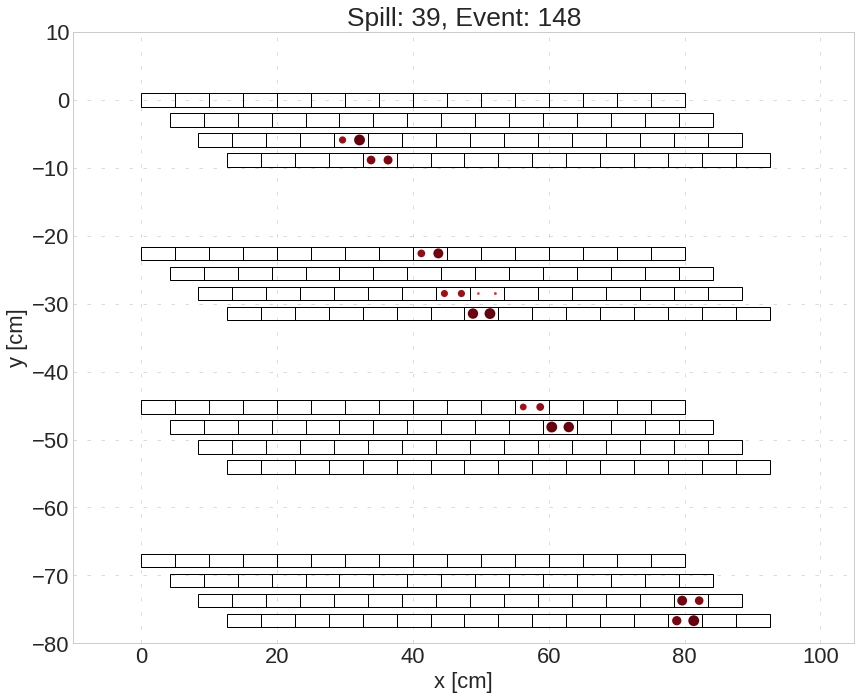

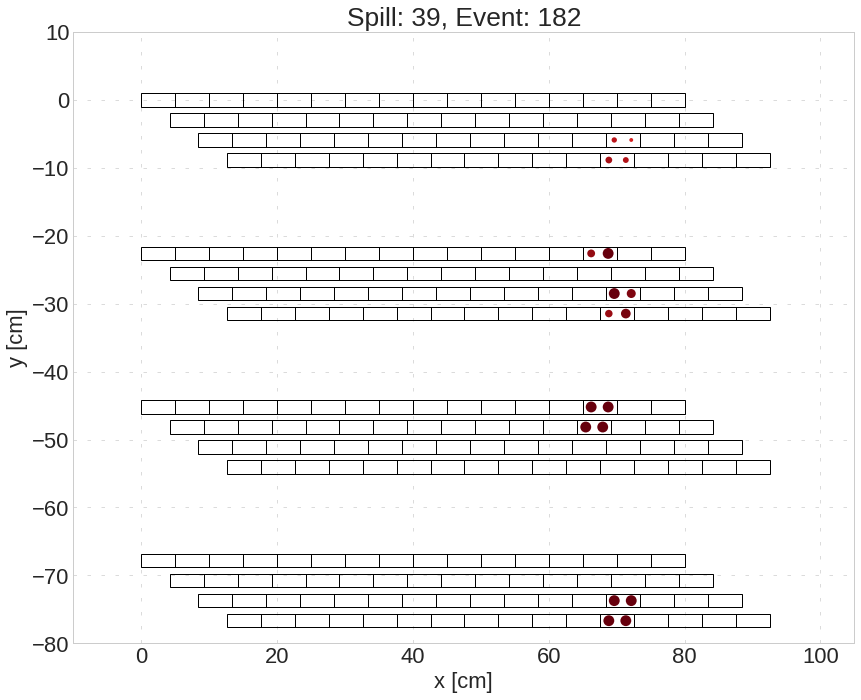

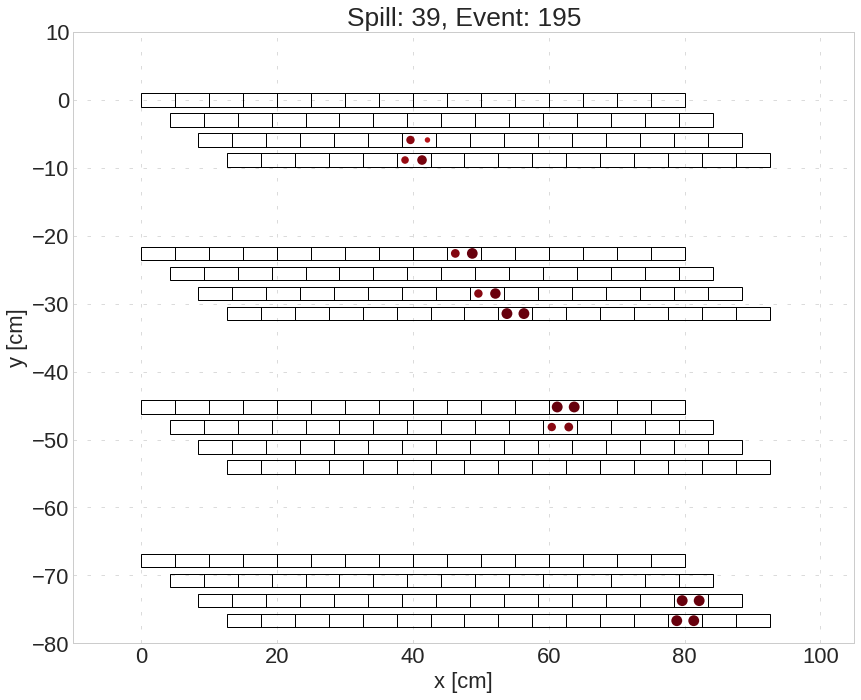

In [15]:
for row in df_failed.head(25).itertuples():
    print(row.spillNumber, row.eventNumber)
    plot_event(row.spillNumber, row.eventNumber)